# Assignment 2 - Question 1
The objective of this assignment is to get you familiarize with  the  problem  of  `Clustering`.

## Instructions
- Write your code and analysis in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of other cells.
- No inbuilt functions to be used until specified

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>_Assignment2_Q1.ipynb`.

In [101]:
import nltk
import re
import numpy as np
import sklearn
import math
import seaborn as sns
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# %pip install sentence-transformers
from sentence_transformers import SentenceTransformer

# Dataset



*   Try to explore the dataset and first understand
*   Steps while processing the dataset:

1.   Load the dataset
>> The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: train and test. Here, we only use train part of the dataset as we don't need any training.

2.   pre-processing of the dataset
>>   A set of basic pre-processing steps are given below, if you can do it better, it is appreciable
3.   Trying to obtain the embeddings for the text. 
>> Here, we used bert model to obtain the embeddings, if you want to use anyother sentence/word embeddings (ELMo,universal sentence encoder, or other bert models) you can use it, but not mandatorily change it)

PS: You need not completely understand how bert works. If you are interested, few links will be mentioned below.

In [3]:
# loading of dataset

from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

# print(list(newsgroups_train))
#['data', 'filenames', 'target_names', 'target', 'DESCR']
# all we require for our task is data and target. 
#target_names describe the different groups present (which are 20) all over the dataset

# print(list(newsgroups_train.target_names))

In [4]:
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [11]:
#preprocessing of sentences and the article

def remove_punct(text):
  text = re.sub('[^a-zA-Z0-9 ]+','', text)
  return text

def remove_urls(text):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  return url_pattern.sub(r'', text)

def remove_tag(text):   
  text=' '.join(text)
  html_pattern = re.compile('<.*?>')
  return html_pattern.sub(r'', text)

def pre_process_sentence(sentence):
  sentence = sentence.lower()
  sentence = remove_punct(remove_urls(sentence))
  return sentence

def pre_process_article(article):
  article = str(article).replace("\n\n|\n", '')
  article = sent_tokenize(article)
  sentences = []
  for each in article:
    if len(each.split(":")) > 1:
      continue
    sentences.append(pre_process_sentence(each))
  return sentences



In [26]:

def get_review_embedding(article):
  sentences = pre_process_article(article)
  sentence_embeddings = bert_model.encode(sentences)

  review_embedding = np.zeros(768)
  for each in sentence_embeddings:
    review_embedding = np.add(np.array(each), review_embedding)

  return review_embedding

embeddings = []
for i in tqdm(range(len(newsgroups_train['data']))):
  embeddings.append(get_review_embedding(newsgroups_train['data'][i]))

labels = list(newsgroups_train.target)


100%|██████████| 11314/11314 [06:33<00:00, 28.77it/s]


In [29]:
import pickle as pkl
embeddings = np.array(embeddings)
with open('embeddings.pkl', 'wb') as f:
    pkl.dump(embeddings, f)
embeddings.shape

(11314, 768)

In [67]:
X, y = embeddings, labels

id_map = {}
for i, label in enumerate(list(newsgroups_train.target_names)):
    id_map[label] = i

Text(0, 0.5, 'Y')

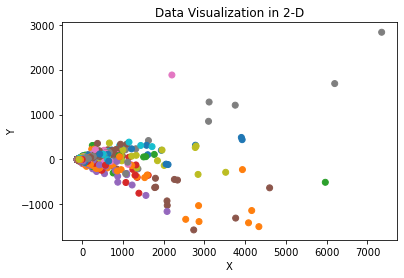

In [84]:
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = np.array(pca.fit_transform(X))
cmap = np.array(sns.color_palette(n_colors=len(set(labels))))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cmap[y])
plt.title('Data Visualization in 2-D')
plt.xlabel('X')
plt.ylabel('Y')

# K_Means Algorithm


In [115]:
from sklearn.cluster import KMeans

pca = PCA(n_components=2)
X_pca = np.array(pca.fit_transform(X))

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_pca)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

Text(0, 0.5, 'Y')

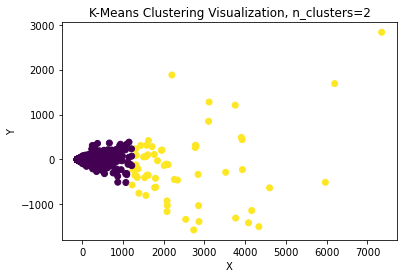

In [118]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_)
plt.title('K-Means Clustering Visualization, n_clusters=2')
plt.xlabel('X')
plt.ylabel('Y')

# Elbow method



*   Try to understand how elbow method works
*   Plot the graph between average distance and the number of clusters
*   Use elbow method to find the optimal number of clusters, 







100%|██████████| 23/23 [01:19<00:00,  3.44s/it]


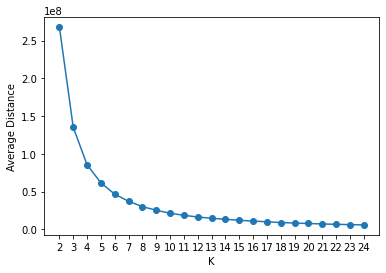

In [104]:
def elbow_method():
    K = range(2, 25, 1)
    mean_wcss_list = []
    for i in tqdm(range(len(K))):
        kmeans = KMeans(n_clusters=K[i], random_state=0).fit(X)
        wcss = kmeans.inertia_
        mean_wcss_list.append(wcss/K[i])

    plt.plot(K, mean_wcss_list, marker='o')
    plt.xlabel('K')
    plt.ylabel('Average Distance')
    Xint = range(min(K), math.ceil(max(K))+1)
    plt.xticks(Xint)
    plt.show()

elbow_method()

In the above plot we can see that a certain elbow shape occurs around **12** (although the curve is quite smooth), hence *using the elbow method* we can say that the number of preferred clusters for the given data (`n_clusters`) could be 12.

# Silhouette Method


*   Compute silhouette score varying the K number of clusters

*   Plot the graph between silhoutte score and number of clusters 

*   Find the optimal number of clusters using silhouette method




> Report the optimal number of clusters you obtained from above two methods (elbow and silhouette)




100%|██████████| 23/23 [02:04<00:00,  5.42s/it]


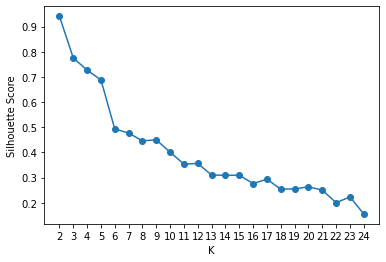

In [105]:
from sklearn.metrics import silhouette_score
def silhouette_scoring():
    K = range(2, 25, 1)
    score_list = []
    for i in tqdm(range(len(K))):
        kmeans = KMeans(n_clusters=K[i], random_state=0).fit(X)
        score_list.append(silhouette_score(X, kmeans.labels_, metric='euclidean'))

    plt.plot(K, score_list, marker='o')
    plt.xlabel('K')
    plt.ylabel('Silhouette Score')
    Xint = range(min(K), math.ceil(max(K)) + 1)
    plt.xticks(Xint)
    plt.show()
  
silhouette_scoring()

From the above plot of K vs Silhouette score, we can see that the highest silhouette score occurs for **k=2**. This implies that the clustering algorithm creates the most distinguishable clustering.  

**The most optimal k:**
- Elbow Method: $12$
- Silhouette Score: $2$

# Agglomerative clustering

In [120]:
from sklearn.cluster import AgglomerativeClustering

def _AgglomerativeClustering(X):
  
  clustering = AgglomerativeClustering().fit(X)
  return clustering.labels_, clustering

Text(0, 0.5, 'Y')

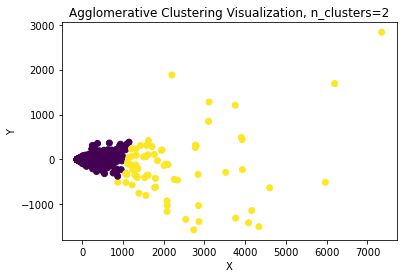

In [121]:
pca = PCA(n_components=2)
X_pca = np.array(pca.fit_transform(X))
labels, model = _AgglomerativeClustering(X_pca)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels)
plt.title('Agglomerative Clustering Visualization, n_clusters=2')
plt.xlabel('X')
plt.ylabel('Y')

# Dendogram


*   Try to understand the difference between agglomerative clustering and divisive clustering
*   Plot dendograms for both kinds of clustering
*   Find the optimal number of clusters with the help of Dendogram



Agglomerative and Divisive are methods to do heirarchial clustering. They are briefly explained below:

- Agglomerative clustering - It uses a bottom-up approach, wherein all the data points are their own clusters, and the clusters are merged up as we move up in a heirarchial fashion, till all points get combined to a single cluster.
- Divisive clustering - It uses a top-down approach, wherein all the data points initally belong to a single cluster, from where we split the cluster into smaller and smaller cluster to create the hierarchy, till all points are their own clusters.

In [126]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

Text(0.5, 0, 'Number of points in node (or index of point if no parenthesis).')

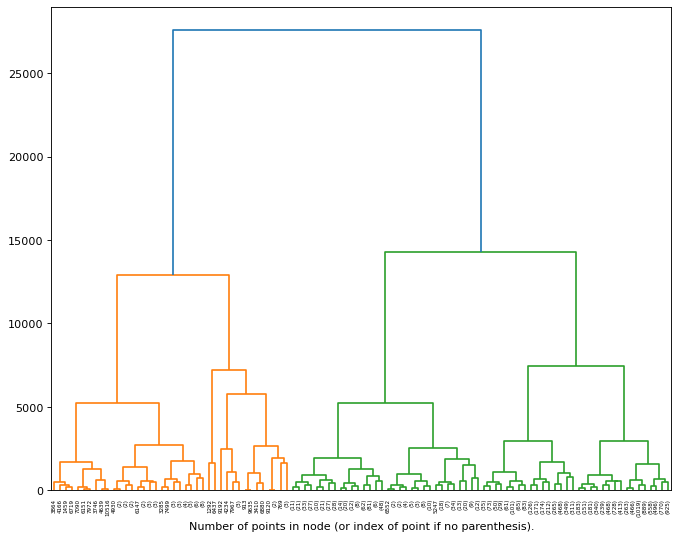

In [132]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X_pca)
plot_dendogram(model, truncate_mode="level", p=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")

The optimal number of clusters according to the dendogram would be **2**, since we would get the most separating cut for 2 clusters.

# useful links to understand BERT

*  https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270#:~:text=How%20BERT%20works,%2Dwords)%20in%20a%20text.&text=As%20opposed%20to%20directional%20models,sequence%20of%20words%20at%20once.


